# House Prices: Advanced Regression Techniques

Predict sales prices and practice feature engineering, RFs, and gradient boosting

In [40]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import metrics

path = "./"
filename_test = os.path.join(path,'test.csv')
# filename_submit = os.path.join(path,'SampleResults3.csv')
filename_train = os.path.join(path,"preprocess_train.csv")
df_train = pd.read_csv(filename_train,na_values=['NA'])
df_train = df_train.drop(['Id'], axis = 1)

# Data preprocessing

In [31]:
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)

def encode(df, zscoreY=False):
# encode dummy and zscores
    if not zscoreY:
        col = filter(lambda name: name != "SalePrice", df_train.columns)
    else:
        col = df_train.columns[:]
        
    for i in range(len(col)):
        colName = col[i]
        if df.dtypes[colName] == 'O':
            encode_text_dummy(df, colName)
        else:
            missing_median(df, colName)
            encode_numeric_zscore(df, colName)

# Cross Validation

In [41]:
def plotUncertainty(model, X, Y):
    n = len(Y)
    pred_Y, sigma = model.predict(X, return_std=True)
    x_range = range(n)
    subRange = x_range[::5]
    subPred_Y = getSubMatrix(pred_Y, subRange)
    sub_sigma = np.array(map(lambda x: sigma[x], subRange))
    
    fig = plt.figure(figsize=(12, 9))
    plt.plot(subRange, getSubMatrix(Y, subRange), 'r.', markersize=10, label=u'Observations')
    plt.plot(subRange, subPred_Y, 'b.', markersize=10, label=u'Prediction')
    plt.fill(np.concatenate([subRange, subRange[::-1]]), np.concatenate([subPred_Y - 128200 * sub_sigma,
                        (subPred_Y + 128200 * sub_sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label='80% confidence interval')
    plt.xlabel('$index$')
    plt.ylabel('$price$')
    plt.legend(loc='upper left')
#     plt.show()
    
def getSubMatrix(M, index):
    res = []
    for ind in index:
        res.append(M[ind])
    return np.concatenate(res)

def crossVal(model, X, Y, ifPlotUncertainty=False):
    kf = KFold(10)

    oos_y = []
    oos_pred = []
    fold = 1
    count = 0
    for train, test in kf.split(X):
        print("Fold #{}".format(fold))

        x_train = X[train]
        y_train = Y[train]
        x_test = X[test]
        y_test = Y[test]
        model = model.fit(x_train,y_train)
        
        pred = model.predict(x_test)
        if ifPlotUncertainty:
            plotUncertainty(model, x_test, y_test)
            plt.show()
            
        i = 0
        while i < len(pred):
            if abs(pred[i] - y_test[i]) > 10000000:
                pred = np.delete(pred, i, 0)
                y_test = np.delete(y_test, i, 0)
                i -= 1
                count += 1
            i += 1
        oos_y.append(y_test)
        oos_pred.append(pred)
        
        # Measure this fold's RMSE
        score = np.sqrt(metrics.mean_squared_error(pred,y_test))
        print("Fold score (RMSE): {}".format(score))
        fold += 1

    # Build the oos prediction list and calculate the error.
    oos_y = np.concatenate(oos_y)
    oos_pred = np.concatenate(oos_pred)
    score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
    print("Final, out of sample score (RMSE): {}".format(score))

# Plot Figure

In [83]:
def plotEigen(eigenvalues, percent=0.8):
    import matplotlib.pyplot as plt

    t = np.arange(0.0, len(eigenvalues), 1)
    fig = plt.figure(figsize=(10,6))
    plt.stem(eigenvalues, label = "eigenvalues")

    # plt.setp(line, 'color', 'r', 'ls', '--')

    plt.xlabel('Principle components')
    plt.ylabel('Eigenvalues')
    plt.title('Score plot')
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    plt.show()
    # plt.savefig("SVD_Eigenvalues.png",bbox_inches='tight', dpi=1200)
    plt.show()
    
    info = sum(eigenvalues)*percent
    curSum = 0
    res = 0
    for i in range(len(eigenvalues)):
        curSum += eigenvalues[i]
        if curSum >= info:
            res = i
            break
    print str(percent*100) + " percent info: " + str(res) + " features"

    cul = [0]*len(eigenvalues)
    sumInfo = sum(eigenvalues)
    for i in range(len(eigenvalues)):
        if i==0:
            cul[i] = eigenvalues[i]/sumInfo
        else:
            cul[i] = eigenvalues[i]/sumInfo + cul[i-1]

    plt.figure(figsize=(10,6))
    plt.stem(cul, label = "accumulative info")

    # plt.setp(line, 'color', 'r', 'ls', '--')

    plt.xlabel('Principle components')
    plt.ylabel('Accumulative info')
    plt.title('Score plot')
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    plt.show()
    # plt.savefig("P1Q2_accumulativeInfo.png",bbox_inches='tight', dpi=1200)
    plt.show()

In [42]:
df_train = pd.read_csv(filename_train,na_values=['NA'])
df_train = df_train.drop(['Id'], axis = 1)
encode(df_train)

header = list(df_train.columns.values)
X = np.hstack((np.mat(df_train[header[:header.index('SalePrice')]]), np.mat(df_train[header[header.index('SalePrice') + 1:]])))
Y = np.mat(df_train['SalePrice']).T

In [25]:
import numpy
numpy.set_printoptions(threshold=numpy.nan)

# Linear Regression

In [47]:
model = LinearRegression()
model = model.fit(X, Y)
crossVal(model, X, Y)

Fold #1
Fold score (RMSE): 21907.3895628
Fold #2
Fold score (RMSE): 28288.6608497
Fold #3
Fold score (RMSE): 26634.0558072
Fold #4
Fold score (RMSE): 38131.4293176
Fold #5
Fold score (RMSE): 35007.1054816
Fold #6
Fold score (RMSE): 38973.0808092
Fold #7
Fold score (RMSE): 27429.6144037
Fold #8
Fold score (RMSE): 27699.1143764
Fold #9
Fold score (RMSE): 59818.2603357
Fold #10
Fold score (RMSE): 25226.5282789
Final, out of sample score (RMSE): 34539.1615156


# Decision Tree and Random Forest

In [35]:
import numpy as np
from sklearn import tree
from sklearn import ensemble
import matplotlib.pyplot as plt


clt = tree.DecisionTreeRegressor()
clt = clt.fit(X, Y)
crossVal(clt, X, Y)

Fold #1
Fold score (RMSE): 35421.5584951
Fold #2
Fold score (RMSE): 41067.3083936
Fold #3
Fold score (RMSE): 33991.6068931
Fold #4
Fold score (RMSE): 43332.1999305
Fold #5
Fold score (RMSE): 37966.8336011
Fold #6
Fold score (RMSE): 28484.7602488
Fold #7
Fold score (RMSE): 27956.621209
Fold #8
Fold score (RMSE): 37237.9866569
Fold #9
Fold score (RMSE): 53656.9212345
Fold #10
Fold score (RMSE): 33601.3835867
Final, out of sample score (RMSE): 37951.9960345


In [49]:
rdf = ensemble.RandomForestRegressor()
rdf.fit(X, Y)
crossVal(rdf, X, Y)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Fold #1


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


Fold score (RMSE): 27313.0637764
Fold #2
Fold score (RMSE): 28397.0536573
Fold #3
Fold score (RMSE): 23917.0213456
Fold #4
Fold score (RMSE): 43271.6010462
Fold #5
Fold score (RMSE): 35128.1239867
Fold #6
Fold score (RMSE): 27040.4946764
Fold #7
Fold score (RMSE): 26052.6945105
Fold #8
Fold score (RMSE): 26055.9576353
Fold #9
Fold score (RMSE): 45482.1742977
Fold #10
Fold score (RMSE): 28928.8207699
Final, out of sample score (RMSE): 31976.8441112


# Gaussian Process

Fold #1


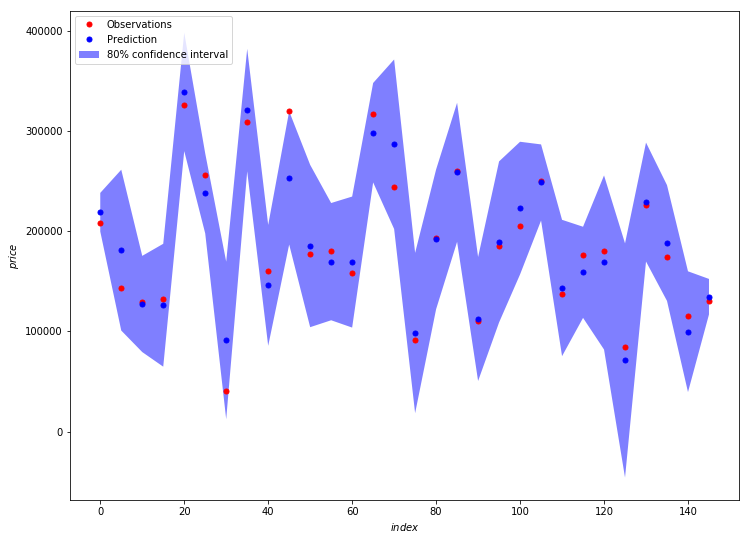

Fold score (RMSE): 29152.0665092
Fold #2


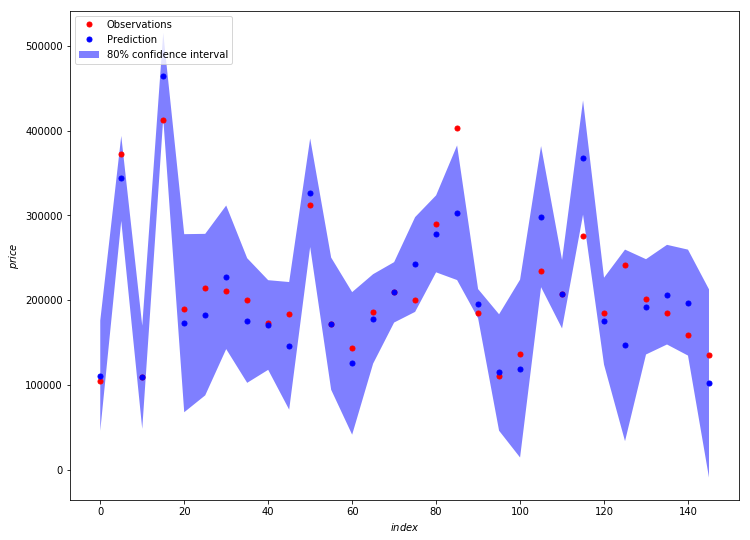

Fold score (RMSE): 51741.6380545
Fold #3


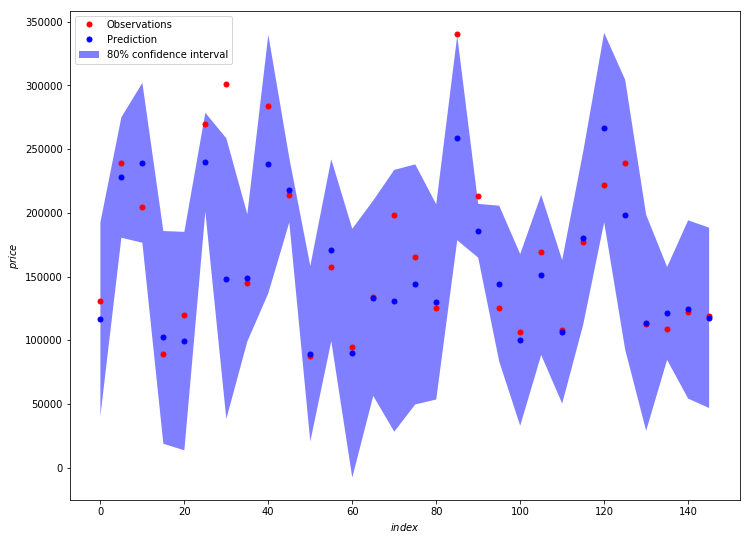

Fold score (RMSE): 44307.0960536
Fold #4


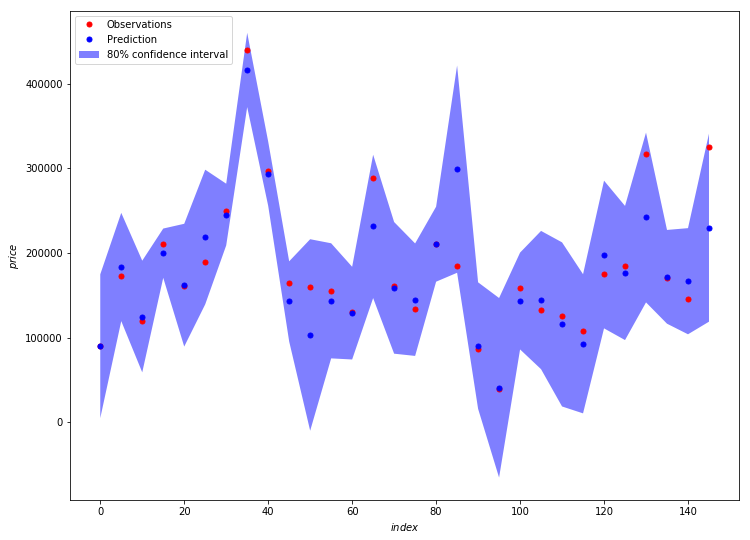

Fold score (RMSE): 33651.124938
Fold #5


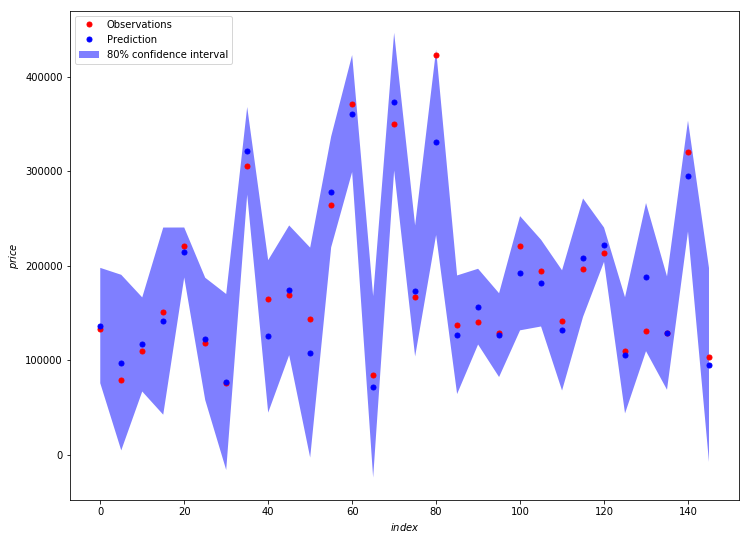

Fold score (RMSE): 49400.0602059
Fold #6


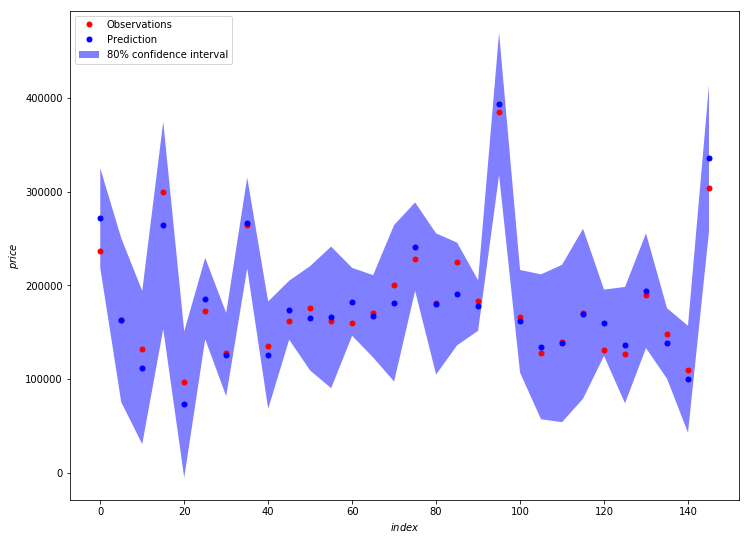

Fold score (RMSE): 38536.9072358
Fold #7


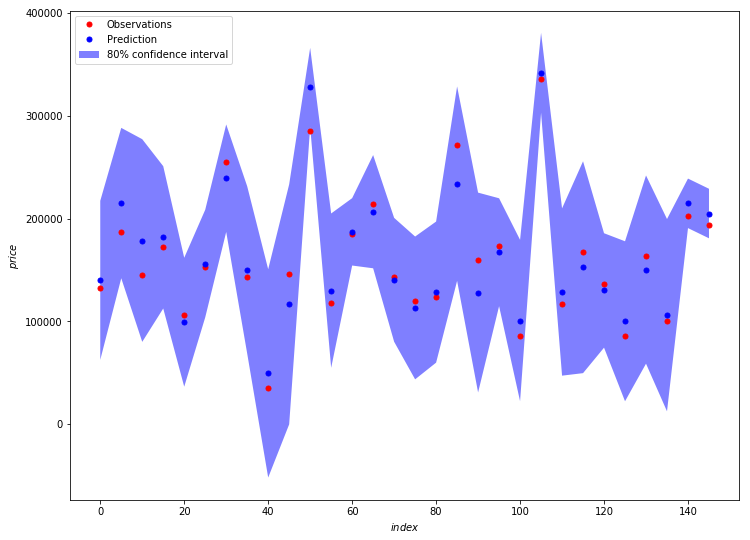

Fold score (RMSE): 30473.8041762
Fold #8


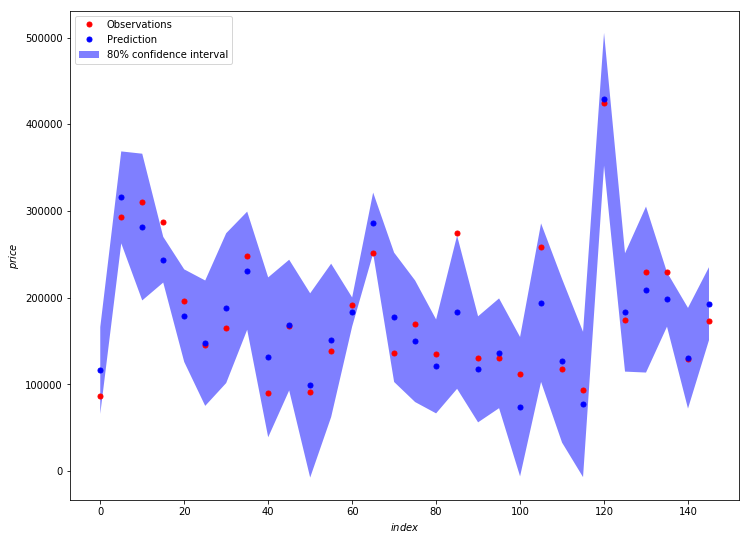

Fold score (RMSE): 23641.5941642
Fold #9


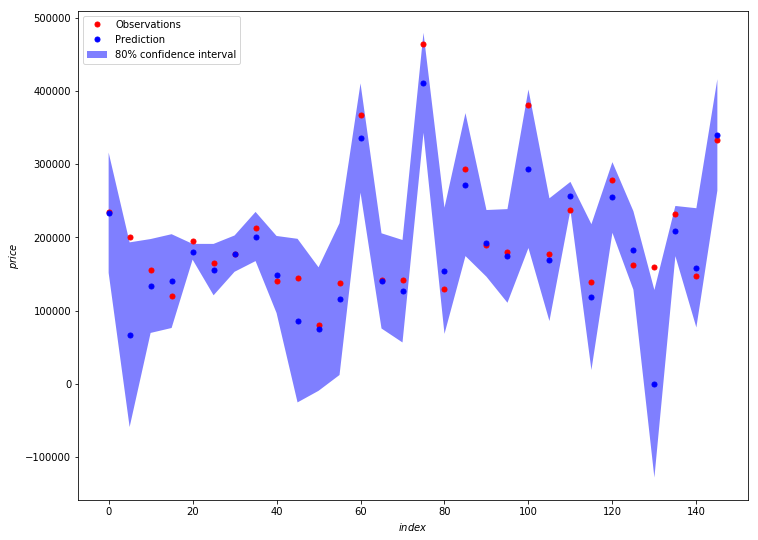

Fold score (RMSE): 48777.341614
Fold #10


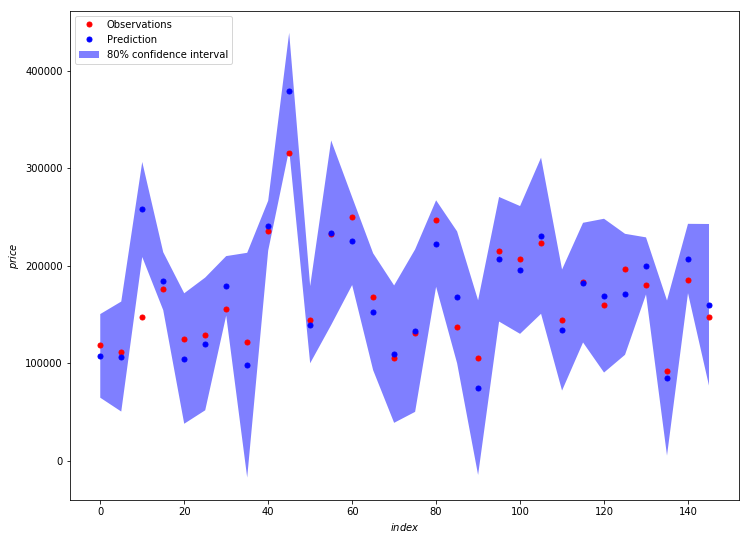

Fold score (RMSE): 25717.0294614
Final, out of sample score (RMSE): 38828.0679446


In [159]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

rbfKernel = RBF(length_scale=1.0)

gp = GaussianProcessRegressor(kernel=rbfKernel)
gp = gp.fit(X, Y)
crossVal(gp, X, Y, ifPlotUncertainty=True)

Fold #1


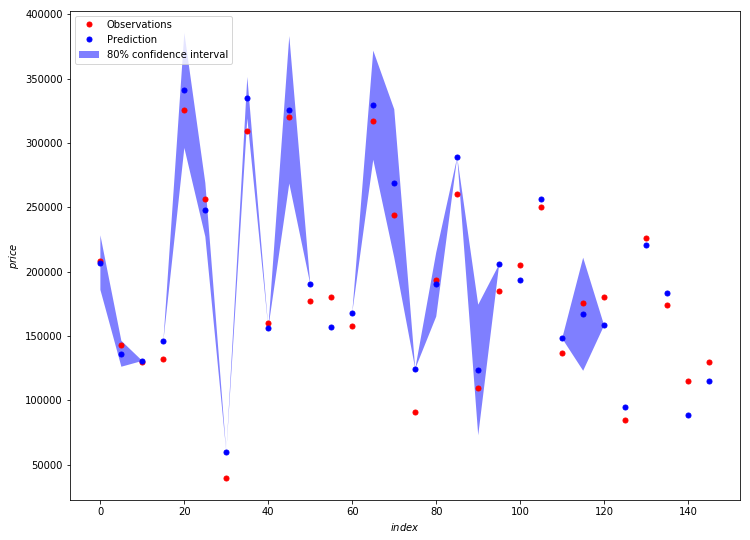

Fold score (RMSE): 21868.6567412
Fold #2


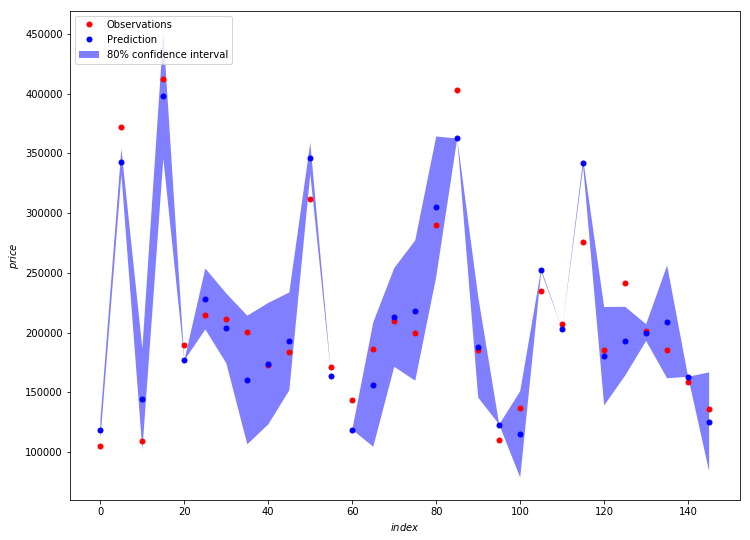

Fold score (RMSE): 28151.3652573
Fold #3


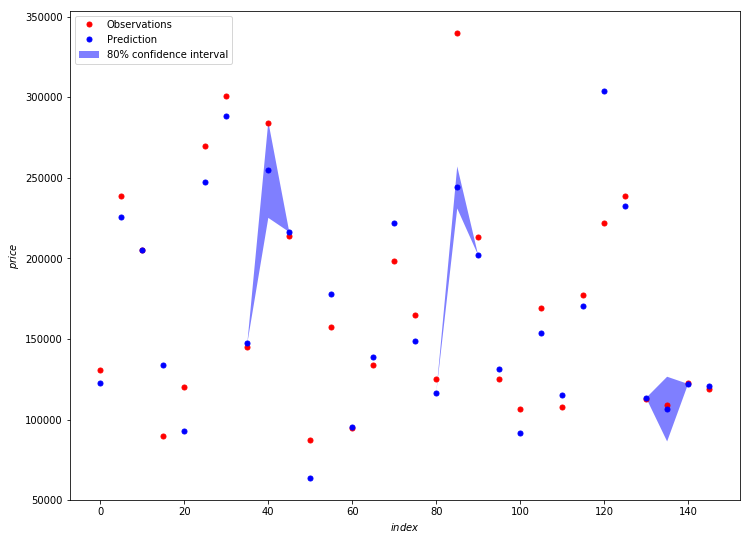

Fold score (RMSE): 26559.8015515
Fold #4


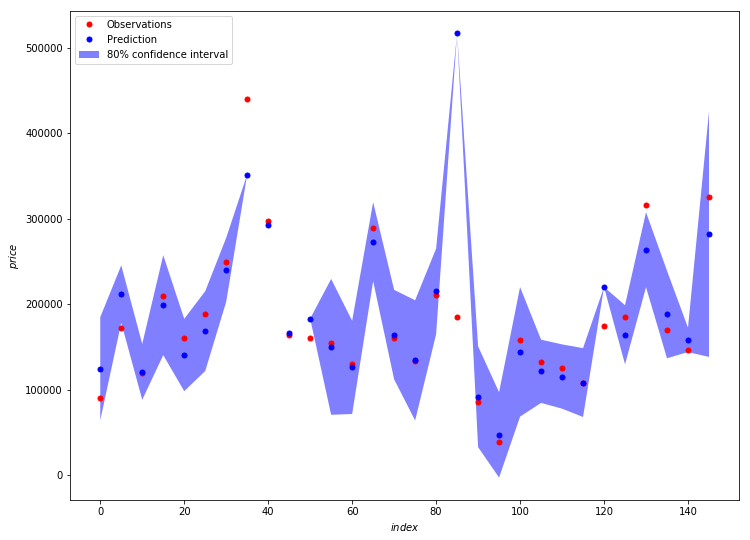

Fold score (RMSE): 38268.8028755
Fold #5


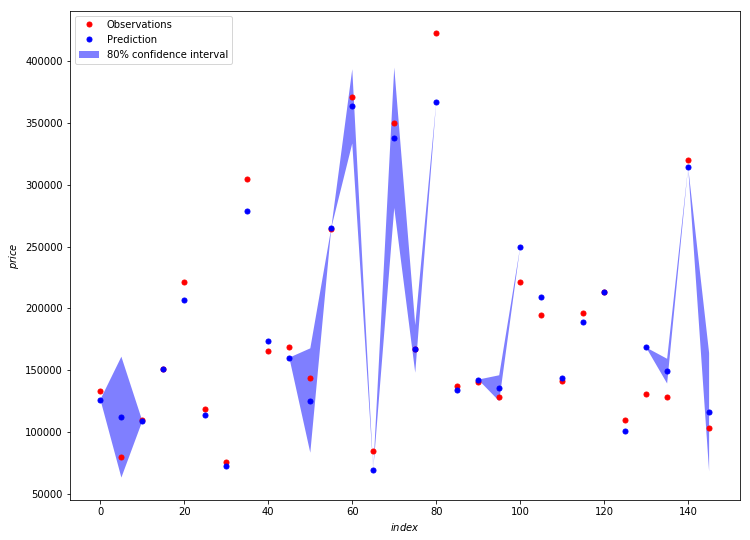

Fold score (RMSE): 34188.43716
Fold #6


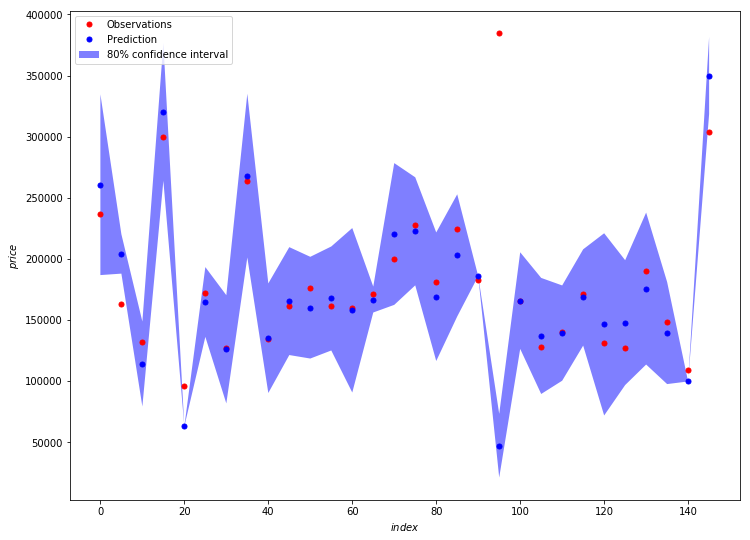

Fold score (RMSE): 38968.1196473
Fold #7


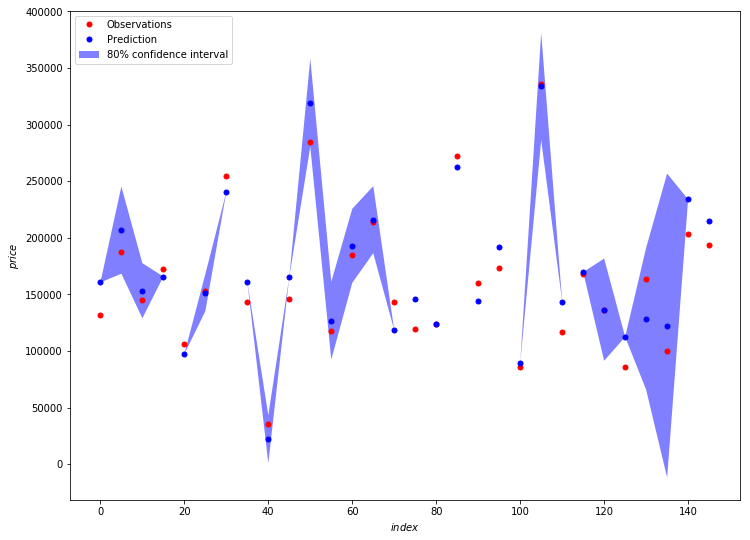

Fold score (RMSE): 27577.0904557
Fold #8


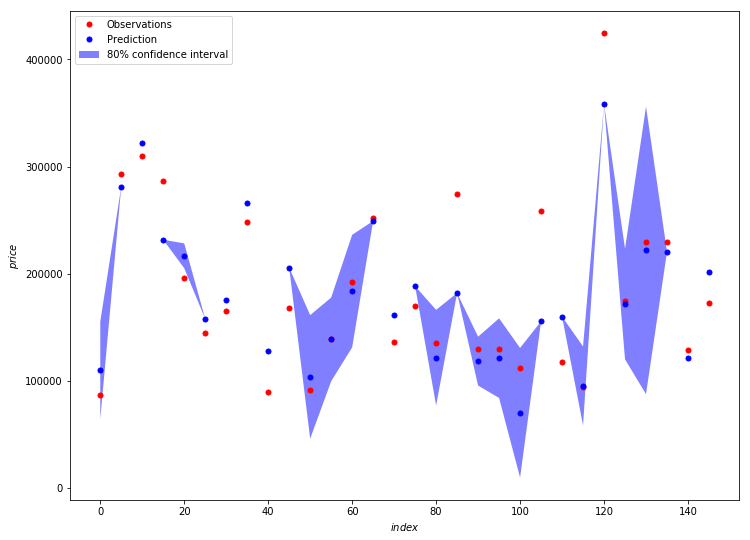

Fold score (RMSE): 27232.1027754
Fold #9


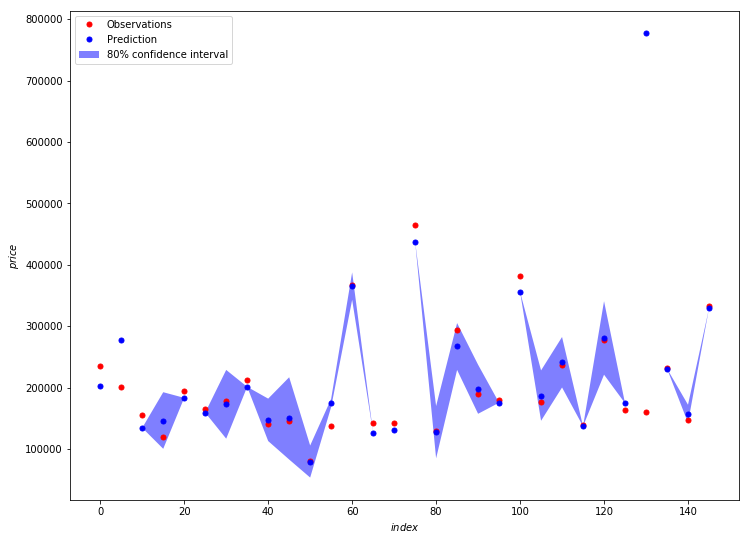

Fold score (RMSE): 59179.8566883
Fold #10


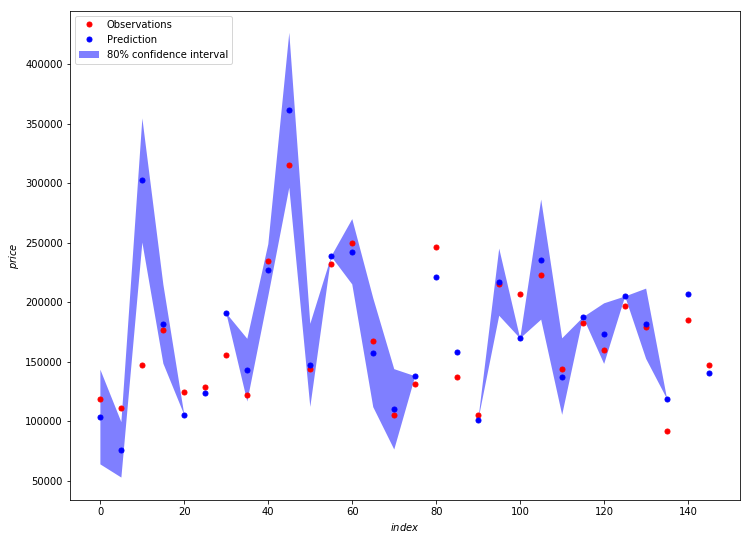

Fold score (RMSE): 25052.8592233
Final, out of sample score (RMSE): 34292.8709243


In [161]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct

polyKernel = DotProduct(sigma_0=1.0)

gp = GaussianProcessRegressor(kernel=polyKernel)
gp = gp.fit(X, Y)
crossVal(gp, X, Y, ifPlotUncertainty=True)

# Support Vector Machine

In [45]:
import numpy as np
from sklearn.svm import SVR
svm = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svm.fit(X, Y)
crossVal(svm, X, Y)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold #1
Fold score (RMSE): 68996.0253007
Fold #2
Fold score (RMSE): 84079.6358253
Fold #3
Fold score (RMSE): 81683.4904858
Fold #4
Fold score (RMSE): 85176.2238453
Fold #5
Fold score (RMSE): 98706.7938844
Fold #6
Fold score (RMSE): 79311.9907458
Fold #7
Fold score (RMSE): 72428.8672957
Fold #8
Fold score (RMSE): 71161.7544062
Fold #9
Fold score (RMSE): 93809.0247799
Fold #10
Fold score (RMSE): 73287.2240129
Final, out of sample score (RMSE): 81407.3263723


# Dimensionality Reduction

In [17]:
import math
import numpy as np
import pandas as pd

path = "./"
filename_test = os.path.join(path,'test.csv')
# filename_submit = os.path.join(path,'SampleResults3.csv')
filename_train = os.path.join(path,"preprocess_train.csv")
df_train = pd.read_csv(filename_train,na_values=['NA'])
df_train = df_train.drop(['Id'], axis = 1)

encode(df_train)

header = list(df_train.columns.values)
X = np.hstack((np.mat(df_train[header[:header.index('SalePrice')]]), np.mat(df_train[header[header.index('SalePrice') + 1:]])))
Y = np.mat(df_train['SalePrice']).T

from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

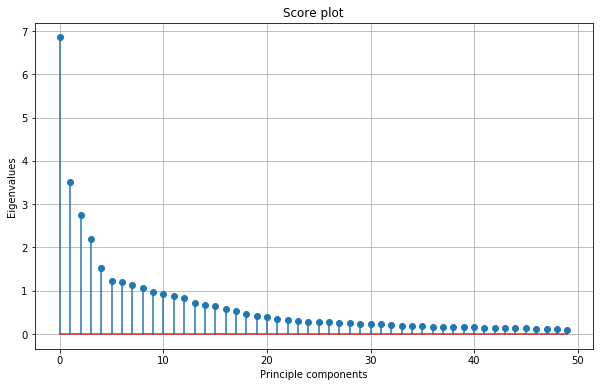

90.0 percent info :28 features


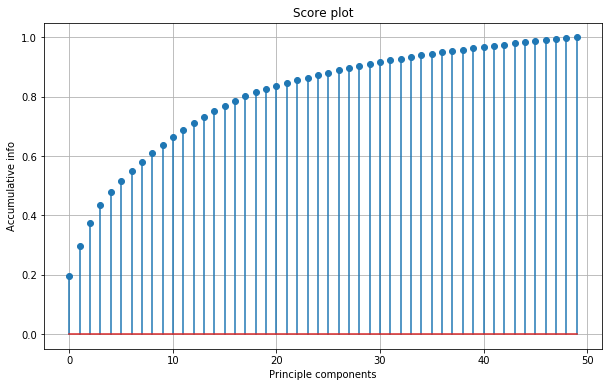

In [79]:
import matplotlib.pyplot as plt

eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

plotEigen(eigenvalues, 0.9)

# Models with PCAed Feature represetation

In [120]:
pca2 = PCA(n_components=28)
pca2.fit(X)
X_pca = pca.transform(X)
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model = model.fit(X_pca, Y)
crossVal(model, X_pca, Y)

Fold #1
Fold score (RMSE): 22758.0134065
Fold #2
Fold score (RMSE): 28024.466951
Fold #3
Fold score (RMSE): 23426.5406155
Fold #4
Fold score (RMSE): 42404.4993933
Fold #5
Fold score (RMSE): 37666.8876178
Fold #6
Fold score (RMSE): 29721.5861557
Fold #7
Fold score (RMSE): 27455.4391316
Fold #8
Fold score (RMSE): 23399.1833805
Fold #9
Fold score (RMSE): 63314.397987
Fold #10
Fold score (RMSE): 25081.4648581
Final, out of sample score (RMSE): 34484.0908176


In [24]:
from sklearn import tree
from sklearn import ensemble
rdf = ensemble.RandomForestRegressor()
rdf.fit(X_pca, Y)
crossVal(rdf, X_pca, Y)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Fold #1


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:40: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fold score (RMSE): 25963.209399
Fold #2
Fold score (RMSE): 30485.5684945
Fold #3
Fold score (RMSE): 26153.6457523
Fold #4
Fold score (RMSE): 42413.3018499
Fold #5
Fold score (RMSE): 36545.3936971
Fold #6
Fold score (RMSE): 22109.1642934
Fold #7
Fold score (RMSE): 23977.5878272
Fold #8
Fold score (RMSE): 25649.5365062
Fold #9
Fold score (RMSE): 43158.2781556
Fold #10
Fold score (RMSE): 27171.9293408
Final, out of sample score (RMSE): 31216.2050758


In [121]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct

polyKernel = DotProduct(sigma_0=1.0)
rbfKernel = RBF(length_scale=1.0)

gp = GaussianProcessRegressor(kernel=polyKernel)
gp = gp.fit(X_pca, Y)
crossVal(gp, X_pca, Y, ifPlotUncertainty=False)

Fold #1
Fold score (RMSE): 22794.1927629
Fold #2
Fold score (RMSE): 28042.0699841
Fold #3
Fold score (RMSE): 23427.3988118
Fold #4
Fold score (RMSE): 42460.4123907
Fold #5
Fold score (RMSE): 37687.594211
Fold #6
Fold score (RMSE): 29730.0908678
Fold #7
Fold score (RMSE): 27450.0051747
Fold #8
Fold score (RMSE): 23383.2217862
Fold #9
Fold score (RMSE): 63326.2087023
Fold #10
Fold score (RMSE): 25089.6811428
Final, out of sample score (RMSE): 34499.0931218


# SVD

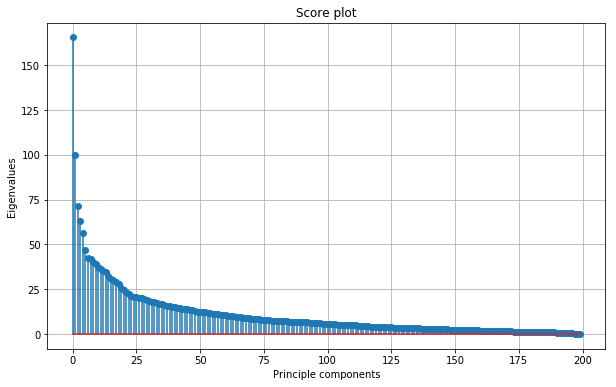

90.0 percent info: 107 features


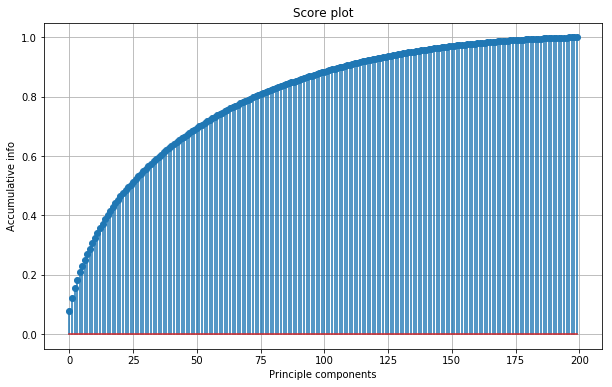

In [94]:
from numpy import linalg as LA
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 200)
svd.fit(X)
sigular_values = svd.singular_values_
plotEigen(sigular_values, 0.9)

# Models with SVDed Feature represetation

In [95]:
svd = TruncatedSVD(n_components = 107)
svd.fit(X)
X_svd = svd.transform(X)

In [96]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model = model.fit(X_svd, Y)
crossVal(model, X_svd, Y)

Fold #1
Fold score (RMSE): 22538.0915009
Fold #2
Fold score (RMSE): 26411.3679064
Fold #3
Fold score (RMSE): 26617.1909557
Fold #4
Fold score (RMSE): 37881.5962697
Fold #5
Fold score (RMSE): 33545.7019868
Fold #6
Fold score (RMSE): 26805.043792
Fold #7
Fold score (RMSE): 27285.7504969
Fold #8
Fold score (RMSE): 25486.1956985
Fold #9
Fold score (RMSE): 55122.8966979
Fold #10
Fold score (RMSE): 25010.1595972
Final, out of sample score (RMSE): 32017.0904093


In [122]:
from sklearn import tree
from sklearn import ensemble
rdf = ensemble.RandomForestRegressor()
rdf.fit(X_svd, Y)
crossVal(rdf, X_svd, Y)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Fold #1


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:40: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fold score (RMSE): 27465.0738931
Fold #2
Fold score (RMSE): 30298.0093237
Fold #3
Fold score (RMSE): 25131.9317294
Fold #4
Fold score (RMSE): 39578.3710976
Fold #5
Fold score (RMSE): 36482.038869
Fold #6
Fold score (RMSE): 21648.3641292
Fold #7
Fold score (RMSE): 23495.1462491
Fold #8
Fold score (RMSE): 27904.5111818
Fold #9
Fold score (RMSE): 52084.7860432
Fold #10
Fold score (RMSE): 26932.6071932
Final, out of sample score (RMSE): 32309.1718287


Fold #1


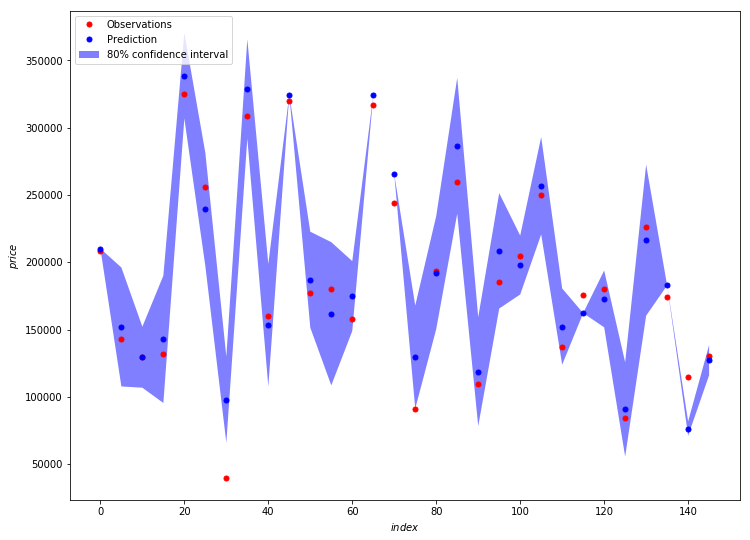

Fold score (RMSE): 22526.0537363
Fold #2


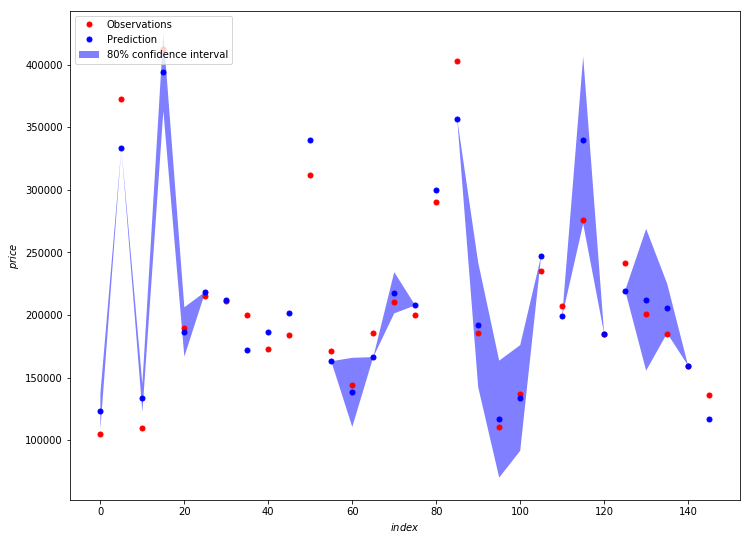

Fold score (RMSE): 26411.1446739
Fold #3


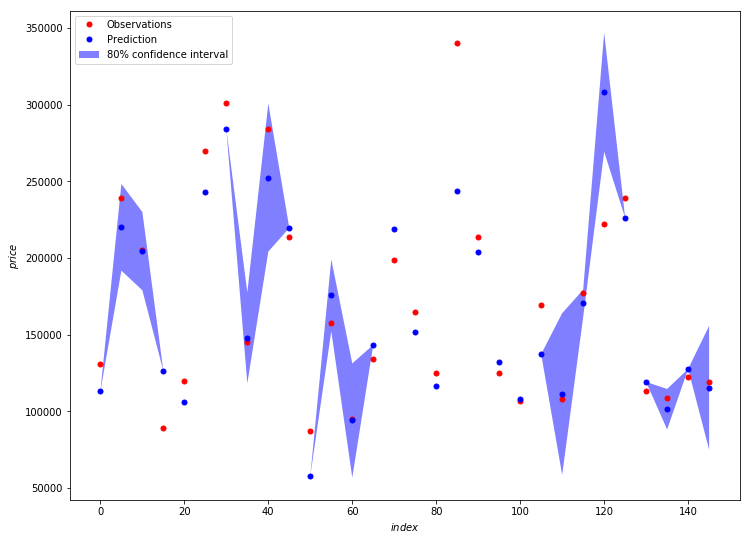

Fold score (RMSE): 26615.9197472
Fold #4


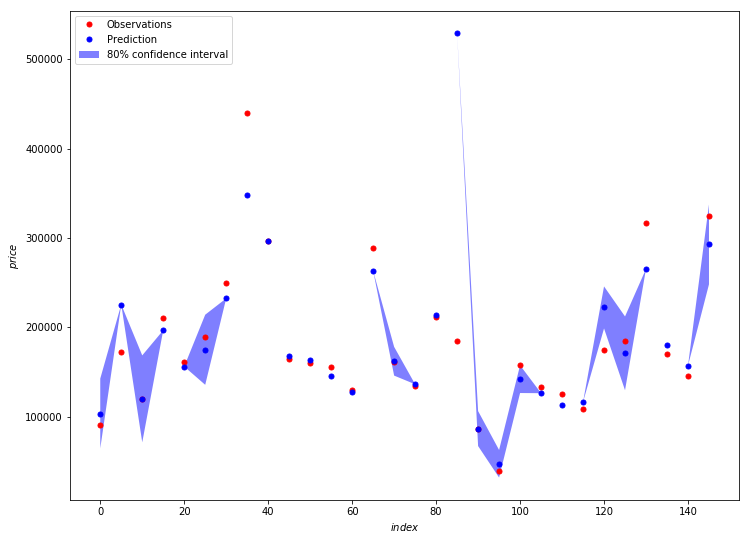

Fold score (RMSE): 37838.0928396
Fold #5


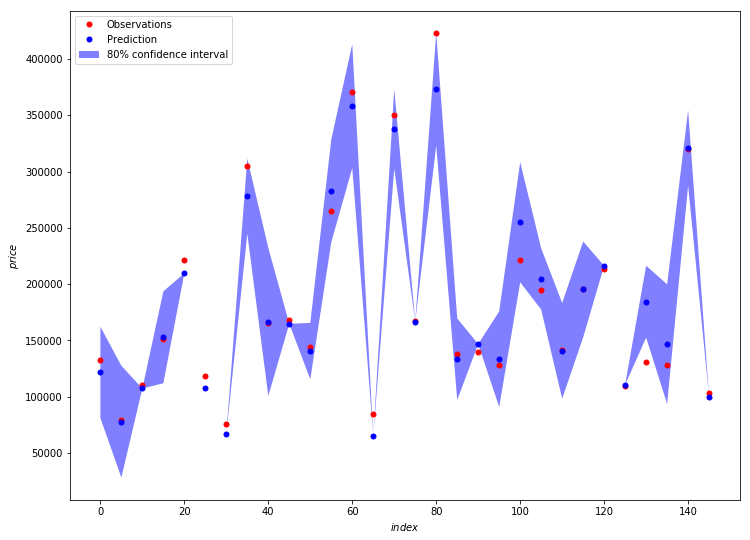

Fold score (RMSE): 33445.6142755
Fold #6


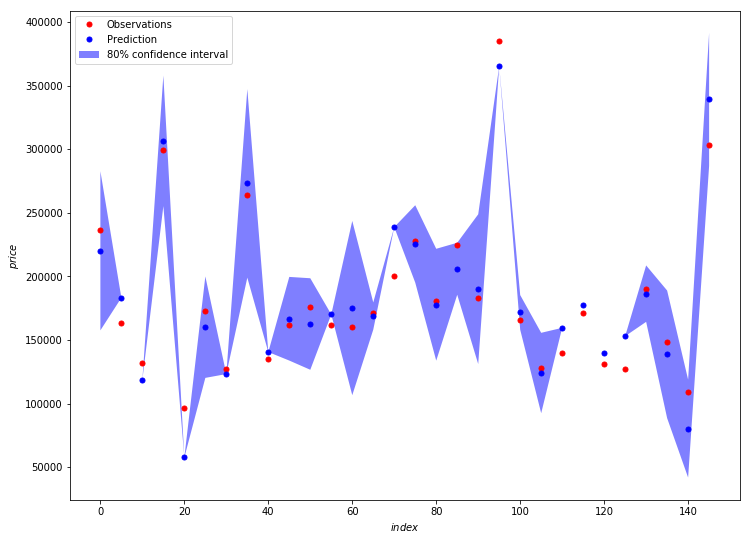

Fold score (RMSE): 26722.8753585
Fold #7


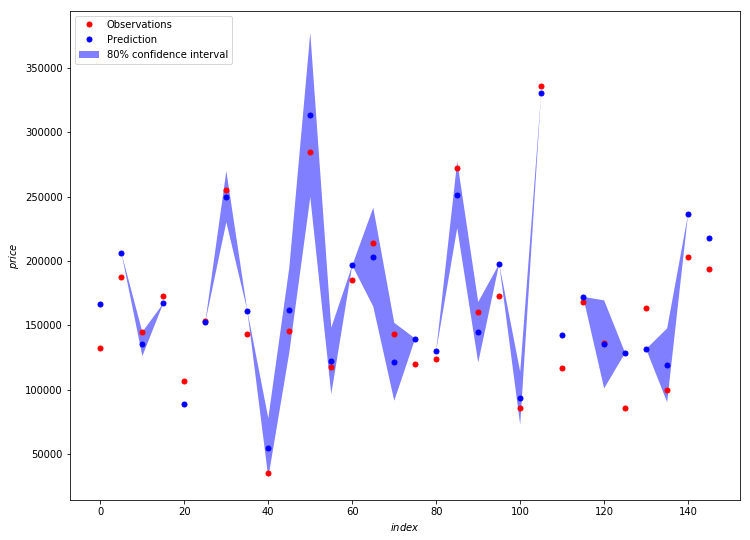

Fold score (RMSE): 27269.420559
Fold #8


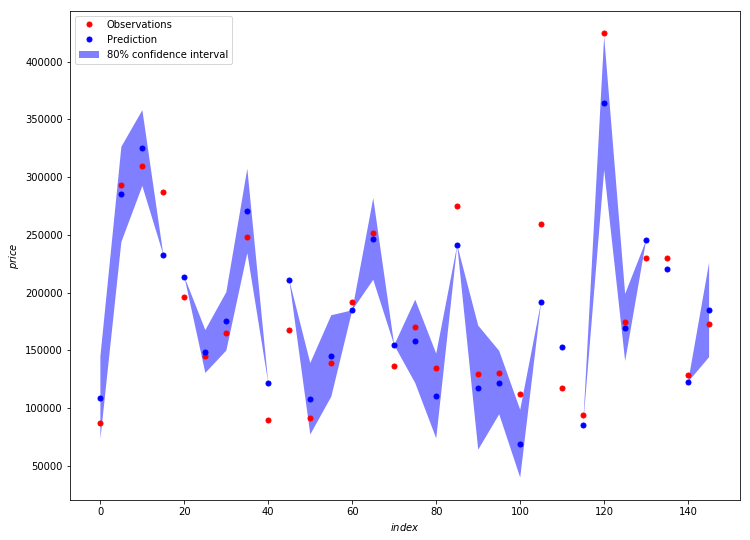

Fold score (RMSE): 25463.4140721
Fold #9


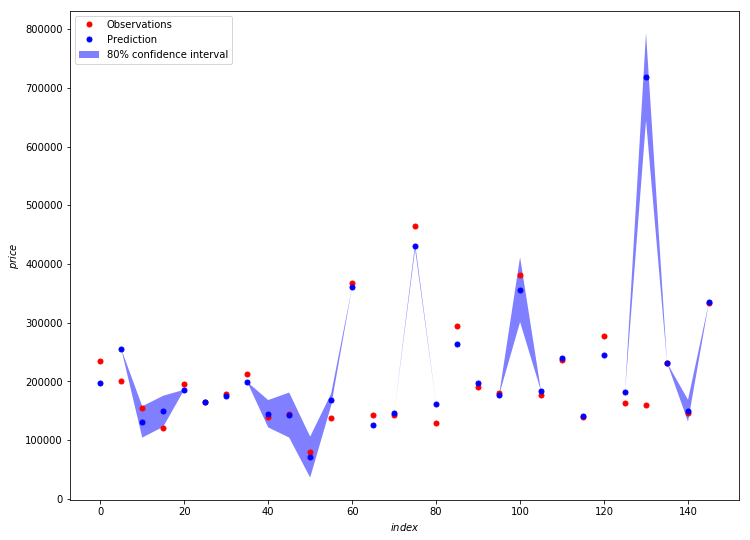

Fold score (RMSE): 55020.4089516
Fold #10


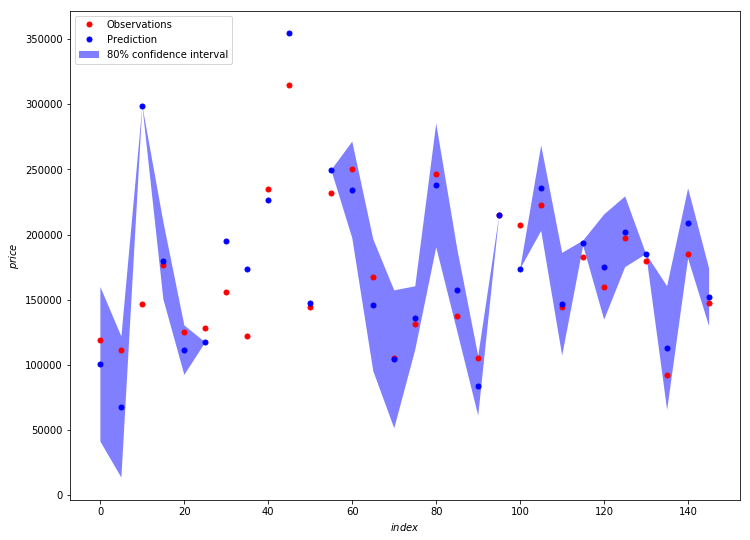

Fold score (RMSE): 24999.8496333
Final, out of sample score (RMSE): 31971.9657388


In [99]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct

polyKernel = DotProduct(sigma_0=1.0)
rbfKernel = RBF(length_scale=1.0)

gp = GaussianProcessRegressor(kernel=polyKernel)
gp = gp.fit(X_svd, Y)
crossVal(gp, X_svd, Y, ifPlotUncertainty=True)

# Neural Network

In [111]:
def NNCrossVal(X, Y):
    import keras
    from keras.models import Sequential
    from keras.layers.core import Dense, Activation
    from keras.callbacks import EarlyStopping
    from keras import regularizers
    from sklearn import metrics
    from sklearn.model_selection import train_test_split
    from sklearn import preprocessing
    from sklearn.model_selection import KFold
    import tensorflow as tf
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import shutil
    import os

    # Cross validate
    kf = KFold(10)

    oos_y = []
    oos_pred = []
    fold = 1
    for train, test in kf.split(X):
        print("Fold #{}".format(fold))

        x_train = X[train]
        y_train = Y[train]
        x_test = X[test]
        y_test = Y[test]

        model = Sequential()
        model.add(Dense(50, input_dim=X.shape[1], activation='relu')) # Hidden 1
        model.add(Dense(25, activation='relu')) # Hidden 2
        model.add(Dense(10, activation='relu'))# Hidden 3
        model.add(Dense(1)) # Output
        model.compile(loss='mean_squared_error', optimizer='adam')
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=50, verbose=1, mode='auto')
        model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)

        pred = model.predict(x_test)    
        oos_y.append(y_test)
        oos_pred.append(pred)

    # Measure this fold's RMSE
        score = np.sqrt(metrics.mean_squared_error(pred,y_test))
        print("Fold score (RMSE): {}".format(score))
        fold += 1

    # Build the oos prediction list and calculate the error.
    oos_y = np.concatenate(oos_y)
    oos_pred = np.concatenate(oos_pred)
    score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
    print("Final, out of sample score (RMSE): {}".format(score))

In [113]:
NNCrossVal(X, Y)

Fold #1
Epoch 00212: early stopping
Fold score (RMSE): 20174.7681085
Fold #2
Epoch 00211: early stopping
Fold score (RMSE): 25137.9494344
Fold #3
Epoch 00206: early stopping
Fold score (RMSE): 21680.3720001
Fold #4
Epoch 00121: early stopping
Fold score (RMSE): 39376.7294519
Fold #5
Epoch 00481: early stopping
Fold score (RMSE): 31719.375625
Fold #6
Epoch 00319: early stopping
Fold score (RMSE): 25726.9369664
Fold #7
Epoch 00239: early stopping
Fold score (RMSE): 24870.758397
Fold #8
Epoch 00243: early stopping
Fold score (RMSE): 21768.9619552
Fold #9
Epoch 00335: early stopping
Fold score (RMSE): 57556.3610098
Fold #10
Epoch 00293: early stopping
Fold score (RMSE): 23274.6993104
Final, out of sample score (RMSE): 31103.6747775


In [112]:
NNCrossVal(X_pca, Y)

Fold #1
Epoch 00296: early stopping
Fold score (RMSE): 22840.6772308
Fold #2
Epoch 00175: early stopping
Fold score (RMSE): 30446.6832253
Fold #3
Epoch 00175: early stopping
Fold score (RMSE): 25746.6507987
Fold #4
Epoch 00373: early stopping
Fold score (RMSE): 44439.2820237
Fold #5
Epoch 00257: early stopping
Fold score (RMSE): 34715.0311053
Fold #6
Epoch 00194: early stopping
Fold score (RMSE): 30505.2864761
Fold #7
Epoch 00252: early stopping
Fold score (RMSE): 26248.9633043
Fold #8
Epoch 00171: early stopping
Fold score (RMSE): 24858.4510212
Fold #9
Epoch 00093: early stopping
Fold score (RMSE): 62808.0962973
Fold #10
Epoch 00161: early stopping
Fold score (RMSE): 26102.5238182
Final, out of sample score (RMSE): 34864.4405225


In [114]:
NNCrossVal(X_svd, Y)

Fold #1
Epoch 00108: early stopping
Fold score (RMSE): 21790.3753486
Fold #2
Epoch 00134: early stopping
Fold score (RMSE): 26465.1572866
Fold #3
Epoch 00103: early stopping
Fold score (RMSE): 25523.3196965
Fold #4
Epoch 00499: early stopping
Fold score (RMSE): 37048.0402128
Fold #5
Epoch 00173: early stopping
Fold score (RMSE): 33150.0848449
Fold #6
Epoch 00141: early stopping
Fold score (RMSE): 26680.7640904
Fold #7
Epoch 00088: early stopping
Fold score (RMSE): 26667.3161854
Fold #8
Epoch 00091: early stopping
Fold score (RMSE): 24883.2768939
Fold #9
Epoch 00089: early stopping
Fold score (RMSE): 55004.7489144
Fold #10
Epoch 00094: early stopping
Fold score (RMSE): 24154.9906928
Final, out of sample score (RMSE): 31542.5468814
